In [1]:
import requests
import json
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

from datetime import datetime
import time

# ----- User Settings 

coins=['BTC']  # Only BTC is available at cryptocompare

collectDataFrom = pd.Timestamp('2016-02-01')


cryptocompare_api_key='777db0605f662ba6667a0c8d385d317262bd221764d4a3b01dc7a629e9592a49'
requestUrls = ['https://min-api.cryptocompare.com/data/blockchain/balancedistribution/histo/day?fsym={}&api_key={}&toTs={}&limit={}',
              'https://min-api.cryptocompare.com/data/v2/histoday?fsym={}&tsym=USD&api_key={}&toTs={}&limit={}']

# ----- User Settings -- end

limit=2000
coin_dfs=[]
for coin in coins:
    time_segments = []
    timestamp = pd.Timestamp.now()
    while collectDataFrom <= timestamp : 
        segment_dfs = []
        for requestUrl in requestUrls:
            segment_df = pd.DataFrame()
            requestUrl = requestUrl.format(coin, cryptocompare_api_key, timestamp.timestamp(),limit)
            print("Request : " + requestUrl)    
            response = requests.get(requestUrl).text 
            parsed = json.loads(response)
            # print("Json : \n\n" + response)
            segment_df = pd.DataFrame(parsed['Data']['Data'])
            segment_df['time'] = pd.to_datetime(segment_df['time'], unit='s')
            segment_df.set_index(['time'],inplace=True, verify_integrity = True, drop = True)
            segment_df.sort_index(inplace=True)
            segment_dfs.append(segment_df)
        
        #segment_df.drop_duplicates(inplace=True)
        concated_segment_dfs= pd.concat(segment_dfs,axis=1)
        time_segments.append(concated_segment_dfs) 
        
        timestamp = segment_df.first_valid_index() - pd.Timedelta(1, "d") # -1 day    
        concated_segment_dfs.drop(columns=['volumefrom','volumeto','conversionType'
                                           ,'conversionSymbol', 'open','high','low'
                                           ,'id','symbol','partner_symbol'], inplace=True)
        #print("seg tail {}".format(concated_segment_dfs.tail(1)))

    df = pd.concat(time_segments, axis=0)
    df.sort_index(inplace=True)
    # print("Df {}\n".format(df))    
    df.dropna(inplace=True)
    df_wallet_ranges = [] 
    for i in range(10):
        df_wallet_range = pd.DataFrame()
        df_wallet_range['addressesCount'] = df['balance_distribution'].map(lambda x: x[i]['addressesCount'])
        df_wallet_range['totalVolume'] = df['balance_distribution'].map(lambda x: x[i]['totalVolume'])
        vindex= df.first_valid_index()  
        range_name = "{}-{}".format(df.loc[vindex,['balance_distribution']][0][i]['from'], df.loc[vindex,['balance_distribution']][0][i]['to'])
        df_wallet_range =  pd.concat({range_name: df_wallet_range}, axis=1, names=["wallet_range", "metrics"]) 
        df_wallet_ranges.append(df_wallet_range)
    range_name = "all"
    df_wallet_range = pd.DataFrame()
    df_wallet_range['price'] = df['close']
    df_wallet_range = pd.concat({range_name: df_wallet_range}, axis=1, names=["wallet_range", "metrics"]) 
    df_wallet_ranges.append(df_wallet_range)
    
    df = pd.concat(df_wallet_ranges, axis=1)
 
    df = pd.concat({coin: df}, axis=1, names=["coin", "wallet_range", "metrics"])
    coin_dfs.append(df)
df=pd.concat(coin_dfs, axis=1)
df=df.loc[collectDataFrom:]
df.sort_index(inplace=True)
df

Request : https://min-api.cryptocompare.com/data/blockchain/balancedistribution/histo/day?fsym=BTC&api_key=777db0605f662ba6667a0c8d385d317262bd221764d4a3b01dc7a629e9592a49&toTs=1681148320.305594&limit=2000
Request : https://min-api.cryptocompare.com/data/v2/histoday?fsym=BTC&tsym=USD&api_key=777db0605f662ba6667a0c8d385d317262bd221764d4a3b01dc7a629e9592a49&toTs=1681148320.305594&limit=2000
Request : https://min-api.cryptocompare.com/data/blockchain/balancedistribution/histo/day?fsym=BTC&api_key=777db0605f662ba6667a0c8d385d317262bd221764d4a3b01dc7a629e9592a49&toTs=1508198400.0&limit=2000
Request : https://min-api.cryptocompare.com/data/v2/histoday?fsym=BTC&tsym=USD&api_key=777db0605f662ba6667a0c8d385d317262bd221764d4a3b01dc7a629e9592a49&toTs=1508198400.0&limit=2000


coin                    BTC                                            \
wallet_range    1e-08-0.001                  0.001-0.01                 
metrics      addressesCount  totalVolume addressesCount   totalVolume   
time                                                                    
2016-02-01          3720460   597.818519        1122004   4019.900070   
2016-02-02          3730327   599.549933        1116246   3992.645470   
2016-02-03          3729060   599.081318        1117260   3999.050294   
2016-02-04          3734713   600.356205        1124074   4024.115666   
2016-02-05          3738924   601.987694        1118292   4002.791264   
...                     ...          ...            ...           ...   
2023-04-04         23467813  4811.598946       10572945  39593.982373   
2023-04-05         23521127  4829.904894       10609372  39711.596112   
2023-04-06         23589264  4846.374203       10628524  39756.963773   
2023-04-07         23650951  4861.820791       10659802  39860.982172   
2023-04-08         23693575  4876.915250       10707422  40007.333499   

coin                                                                     \
wallet_range       0.01-0.1                         0.1-1                 
metrics      addressesCount    totalVolume addressesCount   totalVolume   
time                                                                      
2016-02-01          1232978   38923.513493         677051  2.131989e+05   
2016-02-02          1234923   38917.038726         570656  1.935706e+05   
2016-02-03          1143493   35344.645124         572704  1.941985e+05   
2016-02-04          1152587   35647.296708         579998  1.967851e+05   
2016-02-05          1158224   35818.427166         587802  1.995957e+05   
...                     ...            ...            ...           ...   
2023-04-04          7468763  251078.513151        3306983  1.028420e+06   
2023-04-05          7479515  251435.433355        3309279  1.029016e+06   
2023-04-06          7479795  251396.238547        3310368  1.029296e+06   
2023-04-07          7489841  251704.893109        3311393  1.029769e+06   
2023-04-08          7493114  251749.740947        3311698  1.029825e+06   

coin                                       ...                               \
wallet_range           1-10                ...        10-100       100-1000   
metrics      addressesCount   totalVolume  ...   totalVolume addressesCount   
time                                       ...                                
2016-02-01           321685  9.116889e+05  ...  2.639466e+06          15360   
2016-02-02           326368  9.262344e+05  ...  2.658160e+06          15384   
2016-02-03           327303  9.288237e+05  ...  2.669351e+06          15356   
2016-02-04           330281  9.368918e+05  ...  2.669699e+06          15340   
2016-02-05           333193  9.430400e+05  ...  2.661130e+06          15241   
...                     ...           ...  ...           ...            ...   
2023-04-04           836726  2.088986e+06  ...  4.438709e+06          13994   
2023-04-05           836988  2.089430e+06  ...  4.438416e+06          13996   
2023-04-06           837050  2.089629e+06  ...  4.438424e+06          13972   
2023-04-07           837364  2.089862e+06  ...  4.438157e+06          13976   
2023-04-08           837692  2.090996e+06  ...  4.438453e+06          13977   

coin                                                                    \
wallet_range                   1000-10000                 10000-100000   
metrics        totalVolume addressesCount   totalVolume addressesCount   
time                                                                     
2016-02-01    3.517520e+06           1667  3.385247e+06            105   
2016-02-02    3.514005e+06           1666  3.358658e+06            107   
2016-02-03    3.510309e+06           1664  3.358865e+06            107   
2016-02-04    3.502746e+06           1656  3.335922e+06            108   


In [2]:
df_aux = pd.DataFrame()
#df_aux2 = pd.DataFrame()
coin = 'BTC'

#aggregate_wallets=['0.1-1','1-10', '10-100','100-1000', '1000-10000', '10000-100000', '100000-1000000']
aggregate_wallets=['0.1-1','1-10', '10-100','100-1000', '1000-10000', '10000-100000']


addressCounts = [df[coin][w_range]['addressesCount'] for w_range in aggregate_wallets]
df_aux['addressesCount'] = sum(addressCounts)
df.loc(axis=1)[(coin,'0.1-0','addressesCount')] = df_aux['addressesCount']


aggregate_wallets.append('0.01-0.1')
addressCounts = [df[coin][w_range]['addressesCount'] for w_range in aggregate_wallets]
df_aux['addressesCount'] = sum(addressCounts)
df.loc(axis=1)[(coin,'0.01-0','addressesCount')] = df_aux['addressesCount']


aggregate_wallets.append('0.001-0.01')
addressCounts = [df[coin][w_range]['addressesCount'] for w_range in aggregate_wallets]
df_aux['addressesCount'] = sum(addressCounts)
df.loc(axis=1)[(coin,'0.001-0','addressesCount')] = df_aux['addressesCount']
df.drop(columns=['1e-08-0.001',*aggregate_wallets],inplace=True,level= "wallet_range")


df

coin                    BTC                                          \
wallet_range       100000-0                      all          0.1-0   
metrics      addressesCount    totalVolume     price addressesCount   
time                                                                  
2016-02-01                2  325228.145445    372.18        1107582   
2016-02-02                2  325228.145445    373.92        1006771   
2016-02-03                2  320228.145445    368.02        1010452   
2016-02-04                2  320228.145445    390.65        1020595   
2016-02-05                2  320228.145445    386.46        1030716   
...                     ...            ...       ...            ...   
2023-04-04                4  673305.903250  28178.13        4299706   
2023-04-05                4  673305.903456  28181.03        4302206   
2023-04-06                4  673305.903556  28045.06        4303369   
2023-04-07                4  673305.903578  27910.62        4304701   
2023-04-08                4  673305.903578  27953.79        4305327   

coin                                        
wallet_range         0.01-0        0.001-0  
metrics      addressesCount addressesCount  
time                                        
2016-02-01          2340560        3462564  
2016-02-02          2241694        3357940  
2016-02-03          2153945        3271205  
2016-02-04          2173182        3297256  
2016-02-05          2188940        3307232  
...                     ...            ...  
2023-04-04         11768469       22341414  
2023-04-05         11781721       22391093  
2023-04-06         11783164       22411688  
2023-04-07         11794542       22454344  
2023-04-08         11798441       22505863  

[2624 rows x 6 columns]

In [3]:
def convert_to_m2(df,dt):
    iloc_idx = df.index.get_indexer([dt], method='nearest')  # returns absolute index into df e.g. array([5])
    loc_idx = df.index[iloc_idx]                             # if you want named index
    # my_val = df.iloc[iloc_idx]
    return df.loc[loc_idx,'WM2NS'].values[0] 
df_m2 = pd.read_csv('data/WM2NS.csv')
df_m2['DATE']= pd.to_datetime(df_m2['DATE'])
df_m2.set_index(['DATE'],inplace=True, verify_integrity = True, drop = True)
df.loc(axis=1)[('USD','all', 'm2_supply')] = df.index.map(lambda dt: convert_to_m2(df_m2,dt))

btc_birthday = pd.to_datetime('2009-01-03')
m2_supply_at_genesis = convert_to_m2(df_m2,btc_birthday)
df.loc(axis=1)[('USD','all', 'm2_supply_index')] = df.loc(axis=1)[('USD','all', 'm2_supply')]/m2_supply_at_genesis
df.loc(axis=1)[('BTC','all', 'm2_adj_price')] = df.loc(axis=1)[('BTC','all', 'price')] /df.loc(axis=1)[('USD','all', 'm2_supply_index')]
df


coin                    BTC                                          \
wallet_range       100000-0                      all          0.1-0   
metrics      addressesCount    totalVolume     price addressesCount   
time                                                                  
2016-02-01                2  325228.145445    372.18        1107582   
2016-02-02                2  325228.145445    373.92        1006771   
2016-02-03                2  320228.145445    368.02        1010452   
2016-02-04                2  320228.145445    390.65        1020595   
2016-02-05                2  320228.145445    386.46        1030716   
...                     ...            ...       ...            ...   
2023-04-04                4  673305.903250  28178.13        4299706   
2023-04-05                4  673305.903456  28181.03        4302206   
2023-04-06                4  673305.903556  28045.06        4303369   
2023-04-07                4  673305.903578  27910.62        4304701   
2023-04-08                4  673305.903578  27953.79        4305327   

coin                                             USD                  \
wallet_range         0.01-0        0.001-0       all                   
metrics      addressesCount addressesCount m2_supply m2_supply_index   
time                                                                   
2016-02-01          2340560        3462564   12454.7        1.494803   
2016-02-02          2241694        3357940   12454.7        1.494803   
2016-02-03          2153945        3271205   12454.7        1.494803   
2016-02-04          2173182        3297256   12454.7        1.494803   
2016-02-05          2188940        3307232   12467.4        1.496327   
...                     ...            ...       ...             ...   
2023-04-04         11768469       22341414   21149.1        2.538298   
2023-04-05         11781721       22391093   21149.1        2.538298   
2023-04-06         11783164       22411688   21149.1        2.538298   
2023-04-07         11794542       22454344   21149.1        2.538298   
2023-04-08         11798441       22505863   21149.1        2.538298   

coin                   BTC  
wallet_range           all  
metrics       m2_adj_price  
time                        
2016-02-01      248.982614  
2016-02-02      250.146647  
2016-02-03      246.199639  
2016-02-04      261.338756  
2016-02-05      258.272352  
...                    ...  
2023-04-04    11101.190082  
2023-04-05    11102.332580  
2023-04-06    11048.765192  
2023-04-07    10995.800570  
2023-04-08    11012.808029  

[2624 rows x 9 columns]

In [4]:
df.loc(axis=1)[(coin,'0.1-0','k')] = 21000000*df.loc(axis=1)[(coin,'all','m2_adj_price')] / ( df.loc(axis=1)[(coin,'0.1-0','addressesCount')]
                                                                              * df.loc(axis=1)[(coin,'0.1-0','addressesCount')])

df.loc(axis=1)[(coin,'0.01-0','k')] = 21000000*df.loc(axis=1)[(coin,'all','m2_adj_price')] / ( df.loc(axis=1)[(coin,'0.01-0','addressesCount')]
                                                                              * df.loc(axis=1)[(coin,'0.01-0','addressesCount')])
df.loc(axis=1)[(coin,'0.001-0','k')] = 21000000*df.loc(axis=1)[(coin,'all','m2_adj_price')] / ( df.loc(axis=1)[(coin,'0.001-0','addressesCount')]
                                                                              * df.loc(axis=1)[(coin,'0.001-0','addressesCount')])


df.loc(axis=1)[(coin,'0.001-0', 'k-sma200w')] = df.loc(axis=1)[(coin,'0.001-0','k')].rolling(200*7).mean()
df.loc(axis=1)[(coin,'0.01-0', 'k-sma200w')] = df.loc(axis=1)[(coin,'0.01-0','k')].rolling(200*7).mean()
df.loc(axis=1)[(coin,'0.1-0', 'k-sma200w')] = df.loc(axis=1)[(coin,'0.1-0','k')].rolling(200*7).mean()


df.loc(axis=1)[(coin,'0.001-0', 'k-sma50w')] = df.loc(axis=1)[(coin,'0.001-0','k')].rolling(50*7).mean()
df.loc(axis=1)[(coin,'0.01-0', 'k-sma50w')] = df.loc(axis=1)[(coin,'0.01-0','k')].rolling(50*7).mean()
df.loc(axis=1)[(coin,'0.1-0', 'k-sma50w')] = df.loc(axis=1)[(coin,'0.1-0','k')].rolling(50*7).mean()


df.loc(axis=1)[(coin,'0.001-0', 'k-sma21w')] = df.loc(axis=1)[(coin,'0.001-0','k')].rolling(21*7).mean()
df.loc(axis=1)[(coin,'0.01-0', 'k-sma21w')] = df.loc(axis=1)[(coin,'0.01-0','k')].rolling(21*7).mean()
df.loc(axis=1)[(coin,'0.1-0', 'k-sma21w')] = df.loc(axis=1)[(coin,'0.1-0','k')].rolling(21*7).mean()


df.loc(axis=1)[(coin,'0.001-0', 'k-sma90d')] = df.loc(axis=1)[(coin,'0.001-0','k')].rolling(90).mean()
df.loc(axis=1)[(coin,'0.01-0', 'k-sma90d')] = df.loc(axis=1)[(coin,'0.01-0','k')].rolling(90).mean()
df.loc(axis=1)[(coin,'0.1-0', 'k-sma90d')] = df.loc(axis=1)[(coin,'0.1-0','k')].rolling(90).mean()


df.loc(axis=1)[(coin,'0.001-0', 'k-sma30d')] = df.loc(axis=1)[(coin,'0.001-0','k')].rolling(30).mean()
df.loc(axis=1)[(coin,'0.01-0', 'k-sma30d')] = df.loc(axis=1)[(coin,'0.01-0','k')].rolling(30).mean()
df.loc(axis=1)[(coin,'0.1-0', 'k-sma30d')] = df.loc(axis=1)[(coin,'0.1-0','k')].rolling(30).mean()

df.loc(axis=1)[(coin,'0.001-0', 'k-sma7d')] = df.loc(axis=1)[(coin,'0.001-0','k')].rolling(30).mean()
df.loc(axis=1)[(coin,'0.01-0', 'k-sma7d')] = df.loc(axis=1)[(coin,'0.01-0','k')].rolling(30).mean()
df.loc(axis=1)[(coin,'0.1-0', 'k-sma7d')] = df.loc(axis=1)[(coin,'0.1-0','k')].rolling(30).mean()

# df=df.loc['2013-01-01':]
df

coin                    BTC                                          \
wallet_range       100000-0                      all          0.1-0   
metrics      addressesCount    totalVolume     price addressesCount   
time                                                                  
2016-02-01                2  325228.145445    372.18        1107582   
2016-02-02                2  325228.145445    373.92        1006771   
2016-02-03                2  320228.145445    368.02        1010452   
2016-02-04                2  320228.145445    390.65        1020595   
2016-02-05                2  320228.145445    386.46        1030716   
...                     ...            ...       ...            ...   
2023-04-04                4  673305.903250  28178.13        4299706   
2023-04-05                4  673305.903456  28181.03        4302206   
2023-04-06                4  673305.903556  28045.06        4303369   
2023-04-07                4  673305.903578  27910.62        4304701   
2023-04-08                4  673305.903578  27953.79        4305327   

coin                                             USD                  \
wallet_range         0.01-0        0.001-0       all                   
metrics      addressesCount addressesCount m2_supply m2_supply_index   
time                                                                   
2016-02-01          2340560        3462564   12454.7        1.494803   
2016-02-02          2241694        3357940   12454.7        1.494803   
2016-02-03          2153945        3271205   12454.7        1.494803   
2016-02-04          2173182        3297256   12454.7        1.494803   
2016-02-05          2188940        3307232   12467.4        1.496327   
...                     ...            ...       ...             ...   
2023-04-04         11768469       22341414   21149.1        2.538298   
2023-04-05         11781721       22391093   21149.1        2.538298   
2023-04-06         11783164       22411688   21149.1        2.538298   
2023-04-07         11794542       22454344   21149.1        2.538298   
2023-04-08         11798441       22505863   21149.1        2.538298   

coin                   BTC            ...                                \
wallet_range           all     0.1-0  ...             0.001-0    0.01-0   
metrics       m2_adj_price         k  ...  k-sma21w  k-sma90d  k-sma90d   
time                                  ...                                 
2016-02-01      248.982614  0.004262  ...       NaN       NaN       NaN   
2016-02-02      250.146647  0.005183  ...       NaN       NaN       NaN   
2016-02-03      246.199639  0.005064  ...       NaN       NaN       NaN   
2016-02-04      261.338756  0.005269  ...       NaN       NaN       NaN   
2016-02-05      258.272352  0.005105  ...       NaN       NaN       NaN   
...                    ...       ...  ...       ...       ...       ...   
2023-04-04    11101.190082  0.012610  ...  0.009735  0.000400  0.001444   
2023-04-05    11102.332580  0.012597  ...  0.009763  0.000401  0.001451   
2023-04-06    11048.765192  0.012529  ...  0.009784  0.000403  0.001458   
2023-04-07    10995.800570  0.012461  ...  0.009808  0.000405  0.001465   
2023-04-08    11012.808029  0.012477  ...  0.009833  0.000407  0.001471   

coin                                                                      \
wallet_range     0.1-0   0.001-0    0.01-0     0.1-0   0.001-0    0.01-0   
metrics       k-sma90d  k-sma30d  k-sma30d  k-sma30d   k-sma7d   k-sma7d   
time                                                                       
2016-02-01         NaN       NaN       NaN       NaN       NaN       NaN   
2016-02-02         NaN       NaN       NaN       NaN       NaN       NaN   
2016-02-03         NaN       NaN       NaN       NaN       NaN       NaN   
2016-02-04         NaN       NaN       NaN       NaN       NaN       NaN   
2016-02-05         NaN       NaN       NaN       NaN       NaN       NaN   
...                ...       ...       ... 

In [5]:

k_btc_bottom = 0.00027/20000000
k_btc_top = k_btc_bottom*5.5
df.loc(axis=1)[(coin,'0.001-0', 'k_btc_bottom')] = k_btc_bottom
df.loc(axis=1)[(coin,'0.001-0', 'm2_adj_bottom_price')] = k_btc_bottom * df.loc(axis=1)[(coin,'0.001-0','addressesCount')]**2
df.loc(axis=1)[(coin,'0.001-0', 'bottom_price')] = df.loc(axis=1)[(coin,'0.001-0', 'm2_adj_bottom_price')] * df.loc(axis=1)[('USD','all', 'm2_supply_index')]
df.loc(axis=1)[(coin,'0.001-0', 'k_btc_top')] = k_btc_top
df.loc(axis=1)[(coin,'0.001-0', 'm2_adj_top_price')] = k_btc_top * df.loc(axis=1)[(coin,'0.001-0','addressesCount')]**2
df.loc(axis=1)[(coin,'0.001-0', 'top_price')] =  df.loc(axis=1)[(coin,'0.001-0', 'm2_adj_top_price')] * df.loc(axis=1)[('USD','all', 'm2_supply_index')]




#df.loc(axis=1)[(coin,'0.01-0', 'k-sma30d')] = df.loc(axis=1)[(coin,'0.01-0','k')].rolling(30).mean()
#df.loc(axis=1)[(coin,'0.1-0', 'k-sma30d')] = df.loc(axis=1)[(coin,'0.1-0','k')].rolling(30).mean()


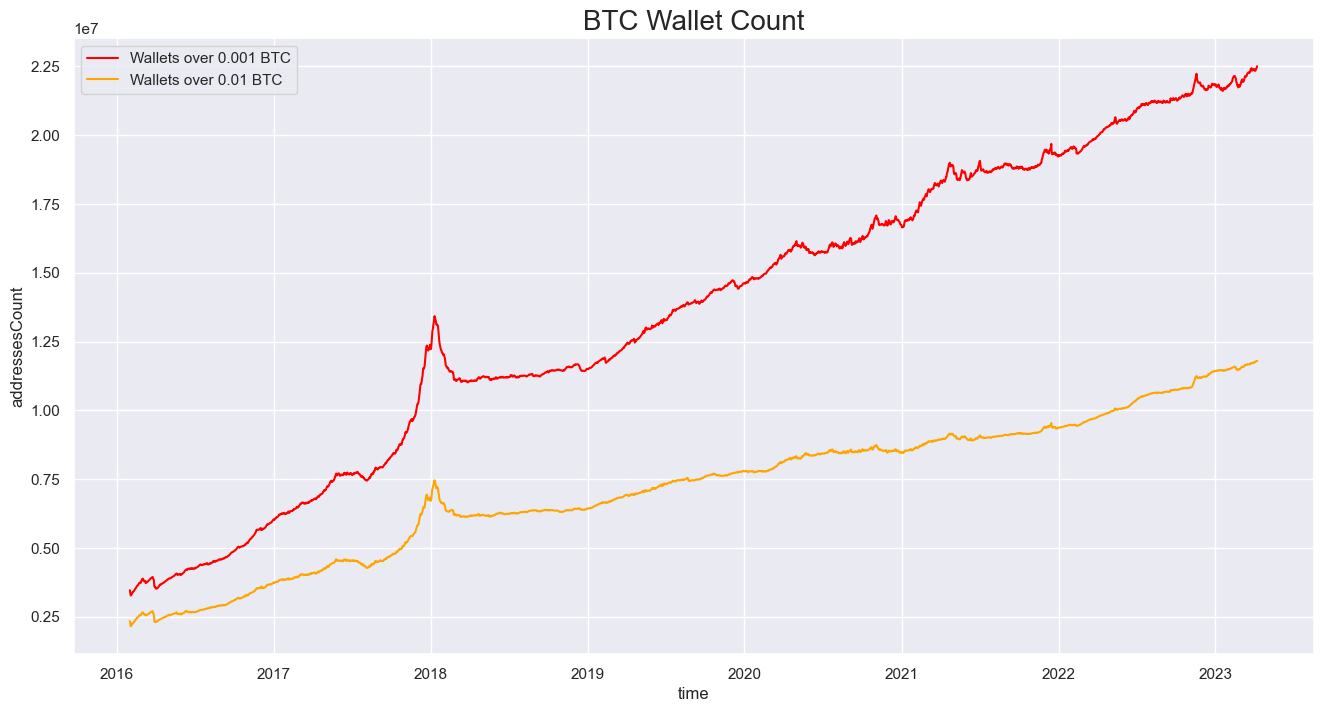

In [6]:
# Apply the default theme
import matplotlib.pyplot as plot
import seaborn as sns
coin='BTC'
sns.set_theme( palette="pastel")
sns.set(rc = {'figure.figsize':(16,8)})

plot.title("{} Wallet Count".format(coin), fontsize=20)

g_results=sns.lineplot(data=df[coin], x=df[coin].index, y=df[coin]['0.001-0']['addressesCount'], color='red',label='Wallets over 0.001 {}'.format(coin))
g_results=sns.lineplot(data=df[coin], x=df[coin].index, y=df[coin]['0.01-0']['addressesCount'], color='orange',label='Wallets over 0.01 {}'.format(coin))

#g_results=sns.lineplot(data=df[coin], x=df[coin].index, y=df[coin]['0.001-0.01']['addressesCount'], color='blue',label='0.001-0.01 Wallets')
#g_results=sns.lineplot(data=df[coin], x=df[coin].index, y=df[coin]['0.01-0.1']['addressesCount'], color='green',label='0.01-0.1 Wallets')
#g_results=sns.lineplot(data=df[coin], x=df[coin].index, y=df[coin]['0.1-1']['addressesCount'], color='red',label='0.1-1 Wallets')


#g_results=sns.lineplot(data=df[coin], x=df[coin].index, y=df[coin][buyAbove], color='red', label=buyAbove)
#g_results=sns.lineplot(data=df[coin], x=df[coin].index, y=df[coin]['trade_usd_value'], color='blue', label='Trading Value {}'.format(buyAbove),linewidth=1)

#g_results.set(yscale='log')
#plot.legend()

[None]

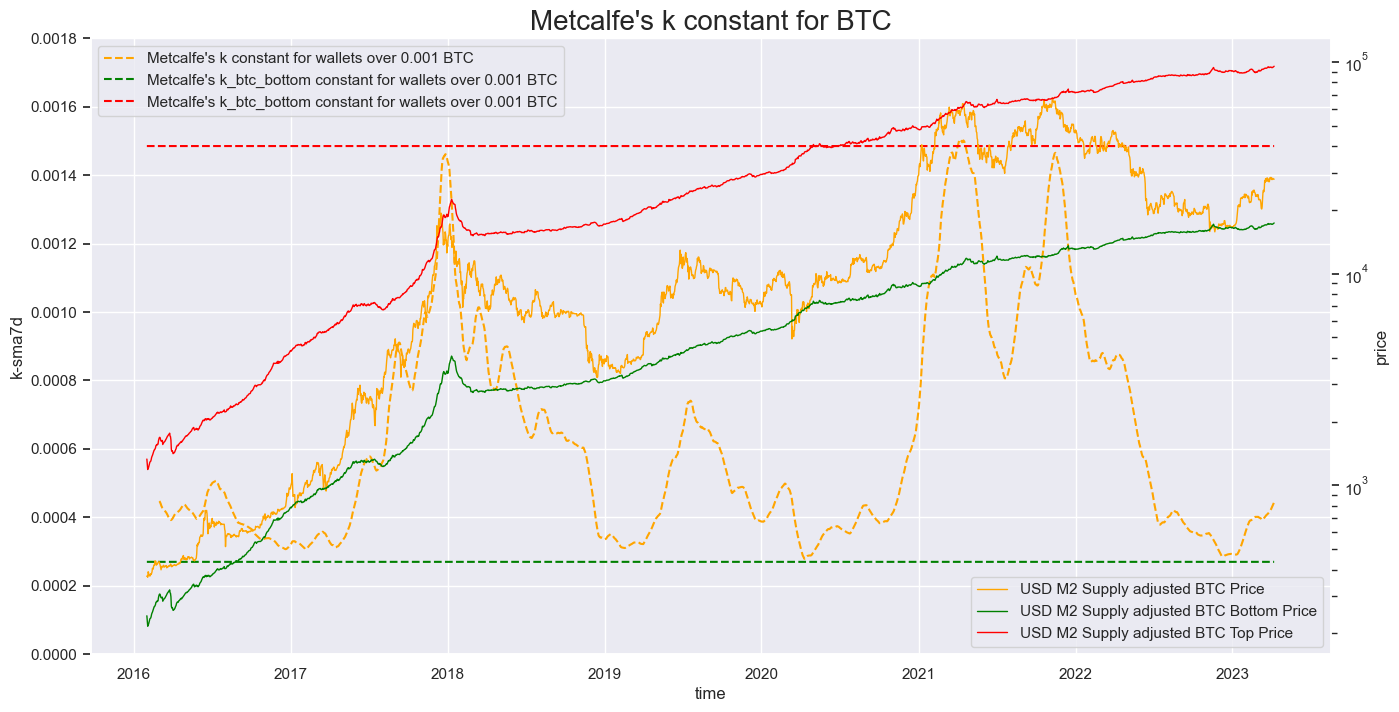

In [7]:
#plot.title("{} k".format(coin), fontsize=20)
fig, ax = plot.subplots()

plot.title("Metcalfe's k constant for {}".format(coin), fontsize=20)

ax.set_ylim(0, 0.0018)
#g_results=sns.lineplot(data=df[coin], x=df[coin].index, y=df[coin]['0.001-0']['addressesCount'], color='red',label='Wallets over 0.001 {}'.format(coin))
#g_results=sns.lineplot(data=df[coin], x=df[coin].index, y=df[coin]['0.01-0']['k-sma30d'], color='orange',label='Metcalfe\'s k constant for wallets over 0.01 {}'.format(coin))
g_results=sns.lineplot(data=df[coin], x=df[coin].index, y=df[coin]['0.001-0']['k-sma7d'], color='orange',label='Metcalfe\'s k constant for wallets over 0.001 {}'.format(coin), linestyle='dashed')
g_results=sns.lineplot(data=df[coin], x=df[coin].index, y=df[coin]['0.001-0']['k_btc_bottom']*20000000, color='green',label='Metcalfe\'s k_btc_bottom constant for wallets over 0.001 {}'.format(coin), linestyle='dashed')
g_results=sns.lineplot(data=df[coin], x=df[coin].index, y=df[coin]['0.001-0']['k_btc_top']*20000000, color='red',label='Metcalfe\'s k_btc_bottom constant for wallets over 0.001 {}'.format(coin), linestyle='dashed')

plot.legend(loc='upper left')
ax2 = plot.twinx()
ax2.grid(False)

#m2_adj_='m2_adj_'
m2_adj_=''

g_results=sns.lineplot(ax=ax2, data=df[coin], x=df[coin].index, y=df[coin]['all'][m2_adj_ + 'price'], linewidth=1, color='orange',label='USD M2 Supply adjusted {} Price'.format(coin))
x = ax2.legend(loc='lower right')
g_results=sns.lineplot(ax=ax2, data=df[coin], x=df[coin].index, y=df[coin]['0.001-0'][m2_adj_ + 'bottom_price'], linewidth=1, color='green',label='USD M2 Supply adjusted {} Bottom Price'.format(coin))
x = ax2.legend(loc='lower right')
g_results=sns.lineplot(ax=ax2, data=df[coin], x=df[coin].index, y=df[coin]['0.001-0'][m2_adj_ + 'top_price'], linewidth=1, color='red',label='USD M2 Supply adjusted {} Top Price'.format(coin))
x = ax2.legend(loc='lower right')

g_results.set(yscale='log')

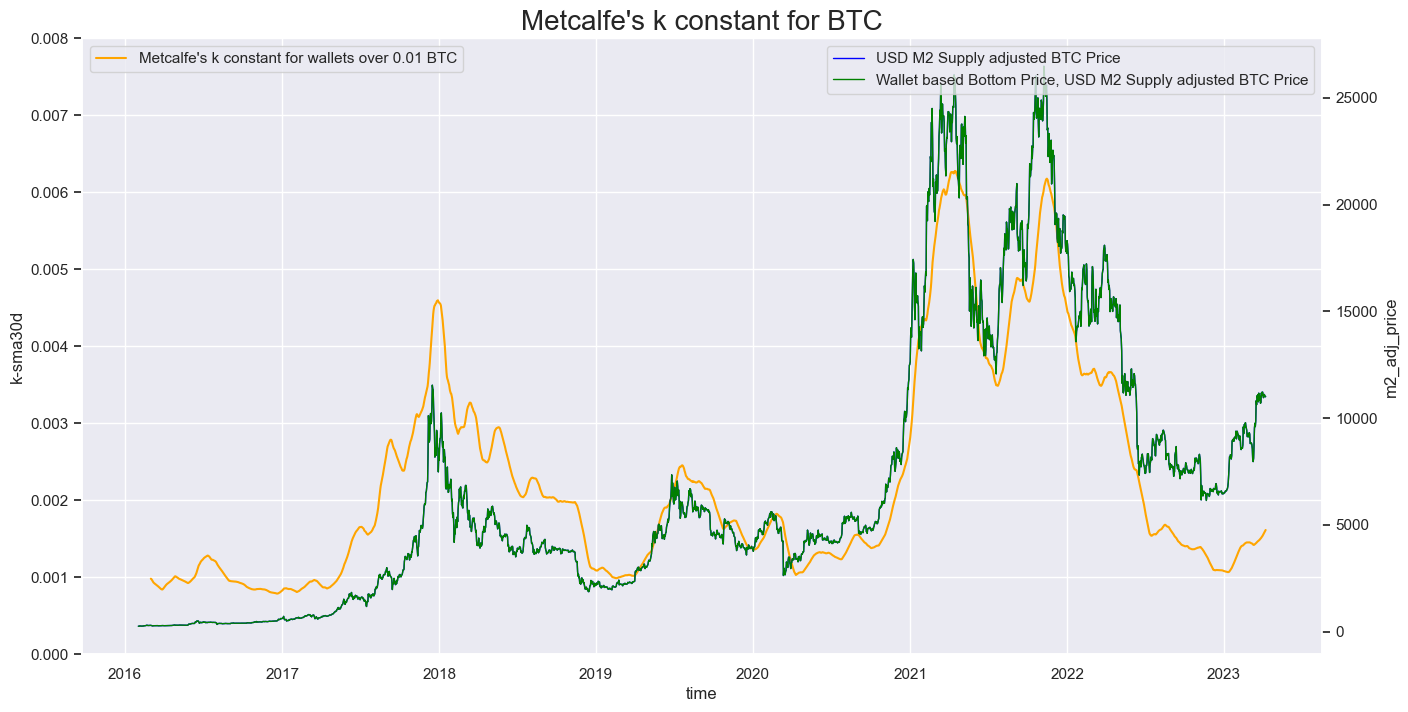

In [8]:
#plot.title("{} k".format(coin), fontsize=20)
fig, ax = plot.subplots()

plot.title("Metcalfe's k constant for {}".format(coin), fontsize=20)

ax.set_ylim(0, 0.008)
g_results=sns.lineplot(data=df[coin], x=df[coin].index, y=df[coin]['0.01-0']['k-sma30d'], color='orange',label='Metcalfe\'s k constant for wallets over 0.01 {}'.format(coin))
#g_results=sns.lineplot(data=df[coin], x=df[coin].index, y=df[coin]['0.001-0']['k-sma30d'], color='red',label='Metcalfe\'s k constant for wallets over 0.001 {}'.format(coin))
#g_results.set(yscale='log')
plot.legend(loc='upper left')
ax2 = plot.twinx()
ax2.grid(False)

g_results=sns.lineplot(ax=ax2, data=df[coin], x=df[coin].index, y=df[coin]['all']['m2_adj_price'], linewidth=1, color='blue',label='USD M2 Supply adjusted {} Price'.format(coin))
x = ax2.legend(loc='upper right')
g_results=sns.lineplot(ax=ax2, data=df[coin], x=df[coin].index, y=df[coin]['all']['m2_adj_price'], linewidth=1, color='green',label='Wallet based Bottom Price, USD M2 Supply adjusted {} Price'.format(coin))
x = ax2.legend(loc='upper right')



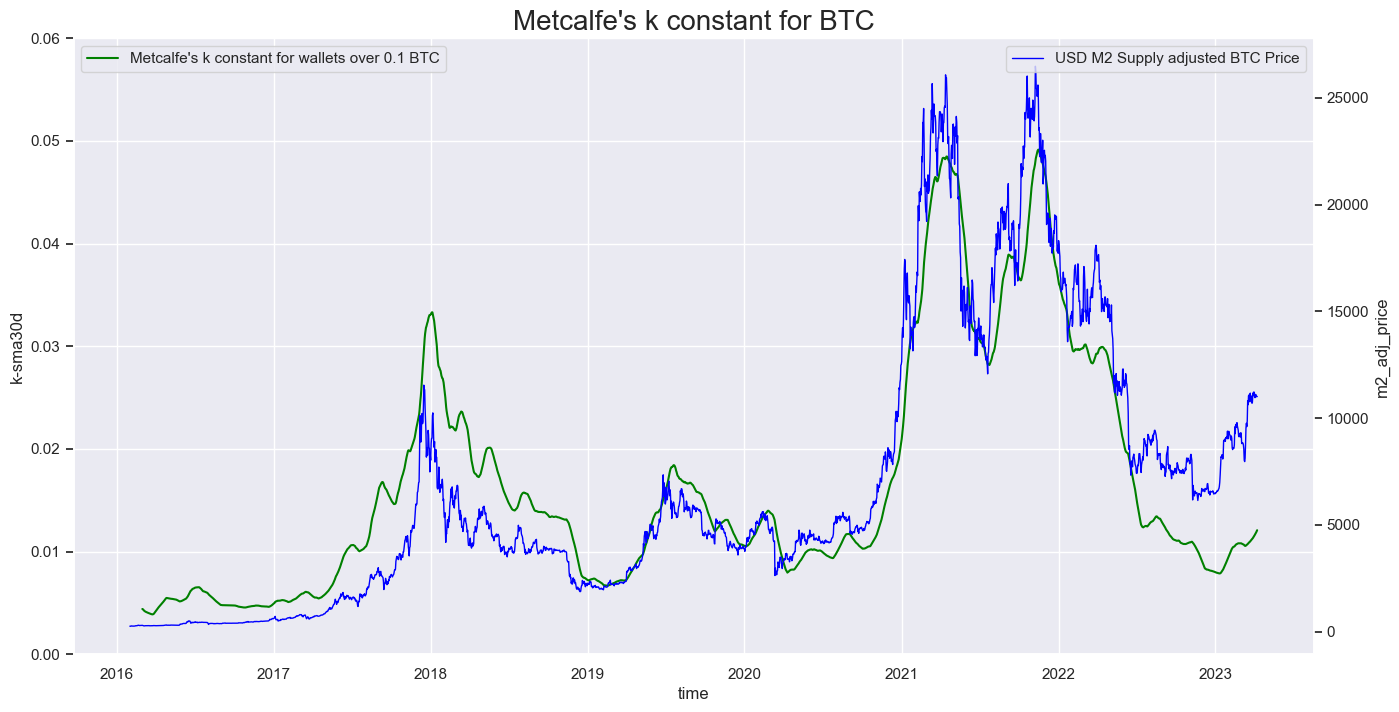

In [9]:
#plot.title("{} k".format(coin), fontsize=20)
fig, ax = plot.subplots()

plot.title("Metcalfe's k constant for {}".format(coin), fontsize=20)

ax.set_ylim(0, 0.06)
g_results=sns.lineplot(data=df[coin], x=df[coin].index, y=df[coin]['0.1-0']['k-sma30d'], color='green',label='Metcalfe\'s k constant for wallets over 0.1 {}'.format(coin))
#g_results.set(yscale='log')
plot.legend(loc='upper left')
ax2 = plot.twinx()
ax2.grid(False)

g_results=sns.lineplot(ax=ax2, data=df[coin], x=df[coin].index, y=df[coin]['all']['m2_adj_price'], linewidth=1, color='blue',label='USD M2 Supply adjusted {} Price'.format(coin))
x = ax2.legend(loc='upper right')
